# Advection equation on oriented graphs

Given a finite oriented graph $G$, we consider the discrete advection equation
$$
\begin{split}
\dfrac{d}{dt}f_t(v)&=-[A_G\,f_t](v)\\
\Rightarrow f_t&=e^{-tA_G}f_0
\end{split}
$$
where $A_G$ represents a _discrete gradient operator_.

### Python libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import networkx as nx
import math
import osmnx as ox
from scipy.linalg import expm
from IPython.display import HTML
import scipy as sp
import os
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['font.family'] = 'CMU Serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12
plt.rcParams['animation.embed_limit'] = 200971520.0

# Basic functions

# Definizioni

In [3]:
def draw_graph(G, ax=None, positional=True, title=None, **kwargs):

    if positional:
        node_pos={u : (G.nodes[u]['x'], G.nodes[u]['y']) for u in G.nodes}
    else:
        node_pos=None

    kwargs.setdefault('with_labels', False)
    kwargs.setdefault('font_size', 16)
    kwargs.setdefault('node_size', 5)
    kwargs.setdefault('width', 1)

    if ax is None:
        ax=plt.gca()

    nx.draw(G, pos=node_pos, ax=ax, **kwargs)
    ax.set_aspect('equal')
    
    if title is not None:
        ax.set_title(title)

In [4]:
def relabel_nodes(G, return_labels=False):
    labels = {}
    for i, u in enumerate(G.nodes):
        labels[u] = i
    J = nx.relabel_nodes(G, labels, copy=True)
    if return_labels:
        return J, labels
    else:
        return J

In [54]:
def bmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    for l in lines:
        elements = [e if not e.endswith('.') else e.rstrip('.') for e in l.split()]
        rv.append('  ' + ' & '.join(elements) + r'\\')
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)


## Laplaciano

Laplaciano combinatorico (pesato con i quadrati delle lunghezze degli archi).

In [5]:
def g_laplacian(G):

    L = np.zeros((len(G), len(G)))
    
    for u in G:
        for v in G.neighbors(u):
            d = G.edges[(u,v)]['distance']
            L[u,u] += 1 / (d**2)
            L[u,v] -= 1 / (d**2)
    return L

## Gradiente

Varie discretizzazioni del gradiente, tra cui $D^{\text{f}}$, $D^{\text{b}}$, $D^{\text{b}'}$ e $D_M$.

In [6]:
def g_gradient(J, type='markov', s=.5):

    if type == 'forward':
        # Forward Gradient (Df)
        # Not stable
        D1 = np.zeros((len(J), len(J)))
        for (u,v) in J.edges:
            D1[u,v] += 1
            D1[u,u] -= 1
        return D1
    elif type == 'backward':
        # Backward Gradient (Db)
        # Does not preserve mass
        D2 = np.zeros((len(J), len(J)))
        for (v,u) in J.edges:  
            D2[u,u] += 1/J.edges[(v,u)]['distance']
            D2[u,v] -= 1/J.edges[(v,u)]['distance']
        return D2
    elif type == 'norm_backward':
        # Mass-preserving backwards Gradient (Db')
        # Does not have the line property
        D3 = np.zeros((len(J), len(J)))
        for (u,v) in J.edges:
            D3[v,u] -= 1/J.edges[(u,v)]['distance']
            D3[u,u] += 1/J.edges[(u,v)]['distance']
        return D3  
    elif type == 'markov':
        D8 = np.zeros((len(J), len(J)))
        # Markov gradient (DM)
        # Preserves mass, positivity
        # Has the line property
        for (u,v) in J.edges:
            D8[v,u] -= 1/J.edges[(u,v)]['distance']/len(list(J.successors(u)))
            D8[u,u] += 1/J.edges[(u,v)]['distance']/len(list(J.successors(u)))
        return D8
    elif type == 'isotropic':
        D10 = np.zeros((len(J), len(J)))
        # Preserves mass, positivity
        # Has the line property
        # Is isotropic
        for (v,u) in J.edges:
            sd = sum([J.edges[(v,w)]['distance'] for w in J.successors(v)])
            D10[u,v] -= 1/sd
            D10[v,v] += 1/sd
        return D10
    elif type == 'weird_isotropic':
        D10 = np.zeros((len(J), len(J)))
        for (v,u) in J.edges:
            sd = sum([1 for w in J.successors(v)])
            D10[u,v] -= 1/sd
            D10[v,v] += 1/sd
        return D10
    elif type == 'weird':
        D9 = np.zeros((len(J), len(J)))
        for (u,v) in J.edges:
            D9[v,u] -= 1/J.edges[(u,v)]['distance']*(s*len(list(J.predecessors(u)))+1)/len(list(J.successors(u)))
            D9[u,u] += 1/J.edges[(u,v)]['distance']*(s*len(list(J.predecessors(u)))+1)/len(list(J.successors(u)))

            D9[u,v] -= s/J.edges[(u,v)]['distance']
            D9[v,v] += s/J.edges[(u,v)]['distance']

        return D9
    else:
        return None

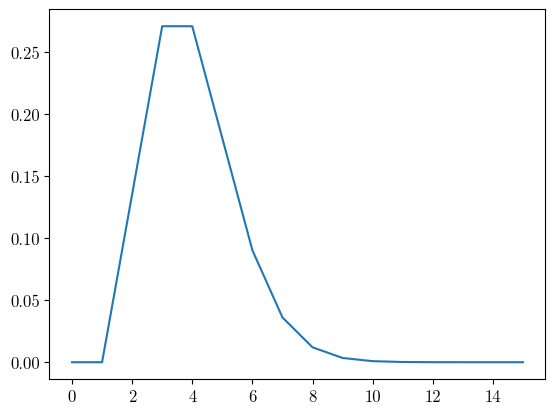

In [89]:
n = 15

J = nx.DiGraph()
J.add_node(0, x=0, y=0) 

for u in range(n):
    J.add_edge(u, (u+1), distance=1)
    J.nodes[u+1]['x'] = u+1
    J.nodes[u+1]['y'] = u+1

D = g_gradient(J, type='markov', s=0)
ft = np.zeros(len(J))
ft[2] = 1
ft  = expm(-2*D) @ ft

plt.figure()
plt.plot(ft)

\begin{bmatrix}
  1 & 0 & 0 & -1\\
  -1 & 1 & 0 & 0\\
  0 & -0.5 & 1 & 0\\
  0 & -0.5 & -1 & 1\\
\end{bmatrix}


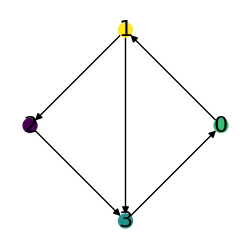

In [71]:
n = 4

J = nx.DiGraph()
for u in range(n):
    J.add_edge(u, (u+1) % n, distance=1)
    J.nodes[u]['x'] = math.cos(u*2*math.pi/n)
    J.nodes[u]['y'] = math.sin(u*2*math.pi/n)

J.add_edge(1, 3, distance=1)
# J.add_edge(1, 4, distance=1)
# J.add_edge(int(2*n/3), 0, distance=1)

# D = g_gradient(J, type='markov')
# D = g_gradient(J, type='norm_backward')
# D = g_gradient(J, type='markov')

# Graph advection
D = g_gradient(J, type='markov', s=0)
ft = np.zeros(len(J))
ft[0] = 1
ft  = expm(-2*D) @ ft

plt.figure(figsize=(3,3))
draw_graph(J, with_labels=True, node_color=ft, node_size=100)

print(bmatrix(D))



In [ ]:
M = 2
t = 1.3
v = np.zeros(n)
v[1] = 1

print(np.linalg.norm(expm(t*(-D)) @ v,1))

print(np.exp(-t*M)*np.linalg.norm(expm(t*(M*np.eye(n)-D)) @ v,1))


eexxp = 0
for k in range(1,20):
    r = v
    for _ in range(k):
        r = (M*np.eye(n)-D) @ r
    eexxp += t ** k / np.math.factorial(k) * r

s = 0
for u in J:
    s += eexxp[u]

print(np.exp(-t*M)*(1+s))



0.9999999999999998
1.0
0.9999999999930627


## Catena di Markov discreta

Costruiamo la matrice $I-J^T$, dove $J$ è stata normalizzata in modo da essere stocastica per riga, e con gli archi uscenti da uno stesso nodo con ugual peso.

In [ ]:
def g_markov(J):
    A = nx.to_numpy_array(J)
    row_sums = A.sum(axis=1)
    A = np.transpose(A / row_sums[:, np.newaxis])
    return A

# Esperimenti numerici

Nel precedente report ho testato il comportamento del _mass-preserving backwards gradient_. Qui testiamo invece il _Markov gradient_.

## Grafo circolare tagliato

Consideriamo un grafo circolare con l'aggiunta di un arco. Ci aspettiamo che la massa si divida equamente nel attraversare o meno quest'arco. Confrontiamo la distribuzione di $f$ dopo un tempo $t\in \mathbb{N}$ ottenuta con il _Markov gradient_ e l'evoluzione della catena di Markov dopo $t$ timesteps. (I risultati sarebbero gli stessi con il _mass-preserving backwards gradient_).

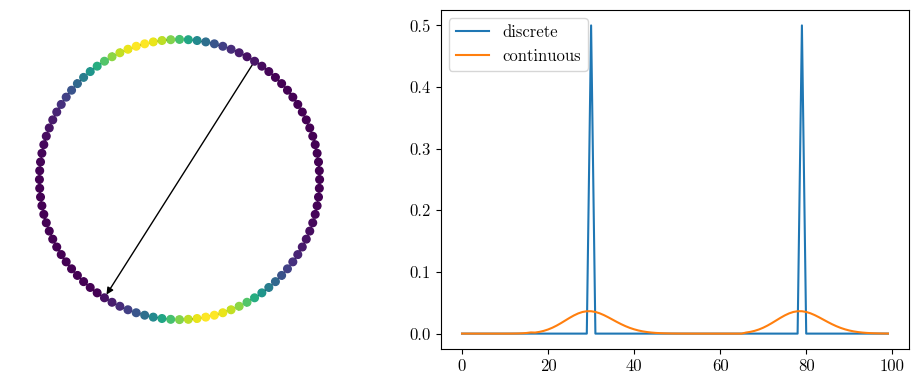

In [ ]:
n = 100

J = nx.DiGraph()
for u in range(n):
    J.add_edge(u, (u+1) % n, distance=1)
    J.nodes[u]['x'] = math.cos(u*2*math.pi/n)
    J.nodes[u]['y'] = math.sin(u*2*math.pi/n)

J.add_edge(int(n/6), int(2*n/3), distance=1)

J = relabel_nodes(J)
G = J.to_undirected()

# Markov process
A = g_markov(J)
f = np.zeros(len(G))
f[0] = 1
for _ in range(30):
    f = A @ f

# Graph advection
D = g_gradient(J, type='markov', s=0)
ft = np.zeros(len(G))
ft[0] = 1
ft  = expm(-30*D) @ ft

fig, ax = plt.subplots(1, 2, figsize=(10,4))
draw_graph(J, ax=ax[0], node_color=ft, node_size=30)
ax[1].plot(f, label='discrete')
ax[1].plot(ft, label='continuous')
ax[1].legend()
fig.tight_layout()

## Distribuzione limite

Osserviamo che per $t\to\infty$, l'equazione di convezione (con il _Markov gradient_) ha lo stesso limite del processo di Markov.

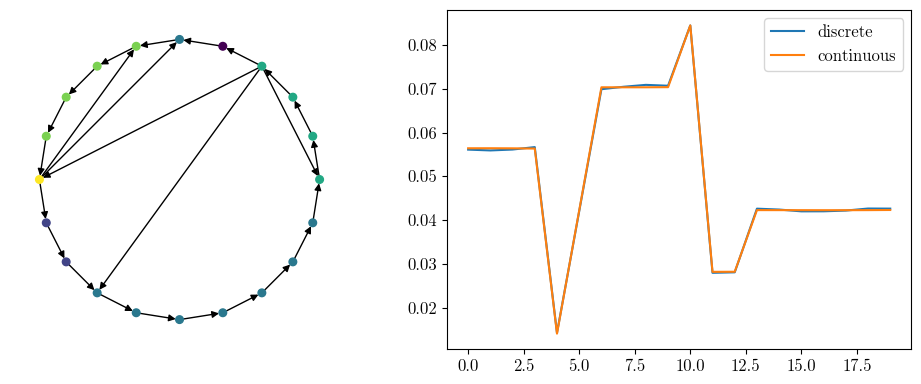

In [ ]:
n = 20

J = nx.DiGraph()
for u in range(n):
    J.add_edge(u, (u+1) % n, distance=1)
    J.nodes[u]['x'] = math.cos(u*2*math.pi/n)
    J.nodes[u]['y'] = math.sin(u*2*math.pi/n)

J.add_edge(int(n/6), int(2*n/3), distance=1)

J.add_edge(int(n/6), int(n/2), distance=1)
J.add_edge(int(n/6), int(0), distance=1)
J.add_edge(int(n/2), int(n/3), distance=1)
J.add_edge(int(n/2), int(n/4), distance=1)

J = relabel_nodes(J)
G = J.to_undirected()

# Combinatorical advection
A = g_markov(J)
f = np.zeros(len(G))
f[0] = 1
for _ in range(100):
    f = A @ f

# Graph advectionv
D = g_gradient(J, type='markov')
ft = np.zeros(len(G))
ft[0] = 1
ft  = expm(-30*D) @ ft

fig, ax = plt.subplots(1, 2, figsize=(10,4))
draw_graph(J, ax=ax[0], node_color=ft, node_size=30)
ax[1].plot(f, label='discrete')
ax[1].plot(ft, label='continuous')
ax[1].legend()
fig.tight_layout()


## Archi con distanze generiche

Consideriamo un grafo lineare dove i primi $20$ nodi hanno lunghezza alternata tra $1$ e $2$. Osserviamo che compaiono dei picchi sui nodi che precedono archi più lunghi (perché la massa ci sta più tempo). Questi picchi spariscono quando la massa si sposta sugli archi con lunghezza uniforme. **Nel fare stime sulla quantità di traffico guardando i nodi in cui c'è un accumulo di massa transitorio, bisogna controllare che non stiamo per lo più misurando i nodi seguiti da archi più lunghi. (Il problema rimane aggiungendo un po' di diffusione)**. [Si veda l'esempio sulle strade di Pisa alla fine.]

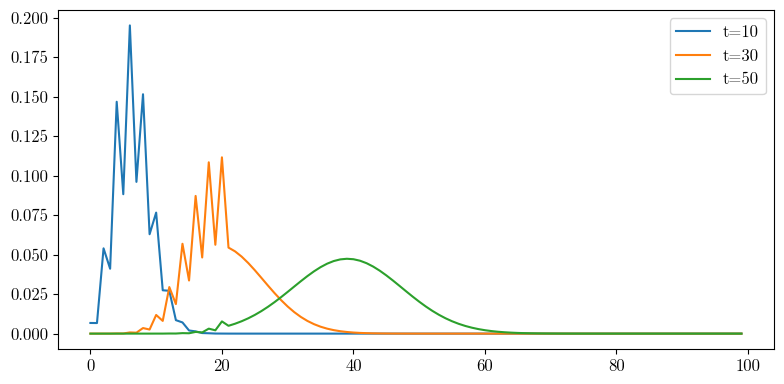

In [ ]:
n = 100

J = nx.DiGraph()
for u in range(n):
    J.add_edge(u, (u+1) % n, distance=2 if u % 2 == 0 and u<=20 else 1)
    J.nodes[u]['x'] = math.cos(u*2*math.pi/n)
    J.nodes[u]['y'] = math.sin(u*2*math.pi/n)

J = relabel_nodes(J)

G = J.to_undirected()

D = g_gradient(J, type='isotropic')
L = g_laplacian(G)
ft = np.zeros(len(G))
ft[0] = 1

fig, ax = plt.subplots(1, figsize=(8,4))

ft  = expm(-10*D) @ ft
ax.plot(ft, label='t=10')

ft  = expm(-20*D) @ ft
ax.plot(ft, label='t=30')

ft  = expm(-20*D) @ ft
ax.plot(ft, label='t=50')

ax.legend()
fig.tight_layout()

### Line property

Osserviamo che il _Markov gradient_ ha la _line property_ su un _lined digraph_ con $200$ nodi (i primi $50$ hanno archi di lunghezza casuale) e vari archi aggiuntivi oltre a quelli standard. Con il _mass-preserving backwards gradient_ **non** si ottiene lo stesso risultato.

Expected value (mass-preserving backward gradient): 	 299.9989378744204
Expected value (Markov gradient): 			 149.99999999999827
0.9675235049632306
0.4837617524816153
1.5907077938885587e-77
3.9883678289352384e-39


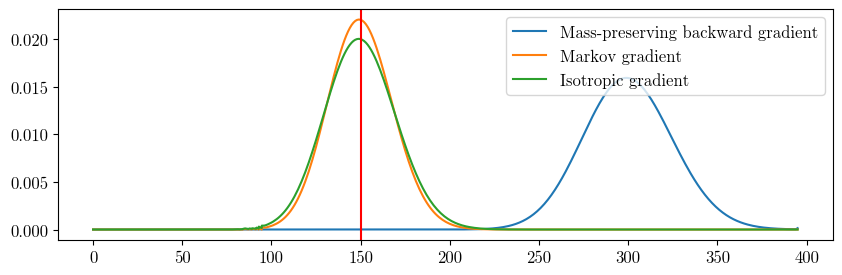

In [ ]:
n = 400

np.random.seed(0)

J = nx.DiGraph()
J.add_node(0, x=0, y=0)
s = 0
for u in range(n):
    d = 2*np.random.rand() if u <= n/4 else 1
    J.add_edge(u, u+1, distance=d)
    s += d
    J.nodes[u+1]['x'] = s
    J.nodes[u+1]['y'] = 0
J.add_edge(n-1, n-1, distance=math.inf)

# J.remove_edge(3,4)
# J.add_edge(3, 5, distance=J.nodes[5]['x']-J.nodes[3]['x'])

for i in range(0,len(J)-3):
    J.add_edge(i, i+3, distance=J.nodes[i+3]['x']-J.nodes[i]['x'])

out_distance = np.zeros(len(J))
for u in J.nodes:
    if u == len(J)-1:
        out_distance[u] = 1
    else:
        out_distance[u] = sum([J.edges[(u, v)]['distance']
                               for v in J.successors(u)])

G = J.to_undirected()

t = 150

Db = g_gradient(J, type='norm_backward')
DM = g_gradient(J, type='markov')
Di = g_gradient(J, type='isotropic')
ft = np.zeros(len(G))
ft[0] = 1
ftb  = expm(-t*Db) @ ft
ftM  = expm(-t*DM) @ ft
fti  = expm(-t*Di) @ ft

plt.figure(figsize=(10,3))
plt.plot([J.nodes[u]['x'] for u in J.nodes], ftb, label='Mass-preserving backward gradient')
plt.plot([J.nodes[u]['x'] for u in J.nodes], ftM, label='Markov gradient')
plt.plot([J.nodes[u]['x'] for u in J.nodes], fti, label='Isotropic gradient')
plt.axvline(t, color='r')
plt.legend()

expected_value_b = sum([J.nodes[u]['x']*ftb[u] for u in J.nodes])
expected_value_M = sum([J.nodes[u]['x']*ftM[u] for u in J.nodes])
print(f'Expected value (mass-preserving backward gradient): \t {expected_value_b}')
print(f'Expected value (Markov gradient): \t\t\t {expected_value_M}')


print(Db[1,1])
print(DM[1,1])

L=max(max([Db[i,i] for i in J]),max([Db[i,i] for i in J]))

print(ftb[0])
print(ftM[0])

# print(np.linalg.norm(expm(-t*Db), np.inf))
# print(np.linalg.norm(expm(-t*DM), np.inf))

# print(np.linalg.norm(L*np.eye(len(J))-Db, 2))
# print(np.linalg.norm(L*np.eye(len(J))-DM, 2))

### Tree isotropy

In [181]:
def dist(J, u, v):
    return nx.shortest_path_length(J, source=u, target=v, weight='distance')

200.00000000000117
200.00000000000117
[1, 501, 701, 826]
0.33333333333333814
0.33333333333333404
0.3333333333333334


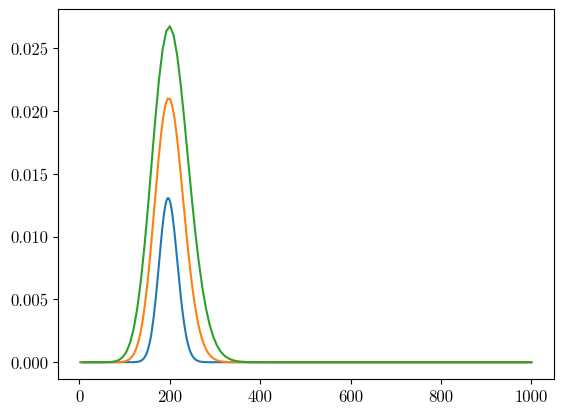

In [188]:

J = nx.DiGraph()

k=1000

j = 0
J.add_node(0, x=0, y=0)
for (i, s) in enumerate([2, 5, 8]):
    for t in range(int(k/s)):
        if t == 0:
            J.add_edge(0, j+1, distance=s)
        else:
            J.add_edge(j, j+1, distance=s)
        J.nodes[j+1]['x'] = dist(J, 0, j+1)
        J.nodes[j+1]['y'] = 3*i
        j += 1

# plt.figure(figsize=(20,10))
# draw_graph(J, with_labels=True, font_size=10, node_size=100, node_color='w')

t = 200
# Graph advection
D = g_gradient(J, type='isotropic')
ft = np.zeros(len(J))
ft[0] = 1
ft  = expm(-t*D) @ ft

# np.set_printoptions(precision=6)
# np.set_printoptions(suppress=True)
# # print(expm(D))
# print(expm(-t*D))

print(sum([ft[i]*J.nodes[i]['x'] for i in J]))
print(sum([ft[u]*dist(J, 0,u) for u in J]))

s = list(J.successors(0)) + [len(J)]

print(s)

print(sum(ft[s[0]:s[1]]))
print(sum(ft[s[1]:s[2]]))
print(sum(ft[s[2]:s[3]]))

plt.figure()
plt.plot([J.nodes[u]['x'] for u in range(s[0],s[1])], ft[s[0]:s[1]])
plt.plot([J.nodes[u]['x'] for u in range(s[1],s[2])], ft[s[1]:s[2]])
plt.plot([J.nodes[u]['x'] for u in range(s[2],s[3])], ft[s[2]:s[3]])

# ft97 = []
# dt = 0.01
# t=0
# for _ in range(150):
#     t += dt
#     ft = np.zeros(len(J))
#     ft[0] = 1
#     ft  = expm(-t*D) @ ft
#     ft97 += [ft[152]]

# plt.figure()
# plt.plot(ft97)


In [ ]:
ft = np.ones(len(J))

print(ft[2])
print(sum((-D@ft)[3:81]))

1.0
1.0


In [ ]:
print(sum(ft[5:81]))


0.13886142675062543


In [ ]:
print(sum(ft97))

0.5454369751105985


### Grafi circolari tangenti


(-4, 0.08330415041482413)
(-3, 0.0771334726063186)
(-2, 0.07404813370206581)
(-1, 0.07250546424993949)
(0, 0.09564550603183515)
(1, 0.07178092282428337)
(2, 0.07187450942509731)
(3, 0.07206168262672519)
(4, 0.07243602902998086)
(5, 0.07318472183649229)
(6, 0.07468210744951514)
(7, 0.07767687867556086)
(8, 0.08366642112765227)


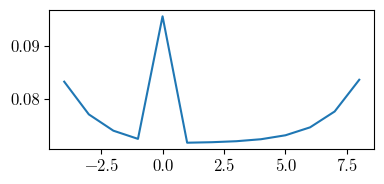

In [191]:
n=5
m=9

J = nx.DiGraph()
for u in range(n):
    J.add_edge(u, (u+1) % n, distance=1/n)
    J.nodes[u]['x'] = -1+math.cos(u*2*math.pi/n)
    J.nodes[u]['y'] = math.sin(u*2*math.pi/n)

for u in range(m):
    J.add_edge(-u, -((u+1) % m), distance=1/m)
    J.nodes[-u]['x'] = 1+math.cos(math.pi-u*2*math.pi/m)
    J.nodes[-u]['y'] = math.sin(math.pi-u*2*math.pi/m)

J = relabel_nodes(J)
G=J.to_undirected()


# fig, ax = plt.subplots(2, 2, figsize=(12,6))
# for i, discretization in enumerate(['norm_backward', 'markov']):
#     D = g_gradient(J, type=discretization)
#     # values, vectors = sp.sparse.linalg.eigs(-D, k=1, sigma=0)
#     # f_eig = np.ndarray.flatten(np.real(vectors))
#     # ax[i,0].plot(abs(f_eig))
#     # ax[i,0].set_title(f'Limit distribution with {discretization} gradient')
    
#     t = 100
#     ft = np.zeros(len(G))
#     ft[0] = 1
#     ft  = expm(-t*D) @ ft
#     draw_graph(J, ax=ax[i,1], node_color=ft, width=0.1, node_size=1000*ft, cmap='coolwarm')
#     ax[i,0].plot(range(-n+1,m), list(np.flip(ft[:n])) + list(ft[n:n+m]))
#     ax[i,1].set_title(f'Distribution at t={t} with {discretization} gradient')
# plt.tight_layout()

plt.figure(figsize=(4,2))
D = g_gradient(J, type='weird', s=1)
# values, vectors = sp.sparse.linalg.eigs(-D, k=1, sigma=0)
# f_eig = np.ndarray.flatten(np.real(vectors))
# ax[i,0].plot(abs(f_eig))
# ax[i,0].set_title(f'Limit distribution with {discretization} gradient')

t = 100
ft = np.zeros(len(G))
ft[0] = 1
ft  = expm(-t*D) @ ft
plt.plot(range(-n+1,m), list(np.flip(ft[:n])) + list(ft[n:n+m]))

print()

for i in zip(range(-n+1,m), list(np.flip(ft[:n])) + list(ft[n:n+m])):
    print(i)


plt.savefig('2.pdf')
plt.tight_layout()

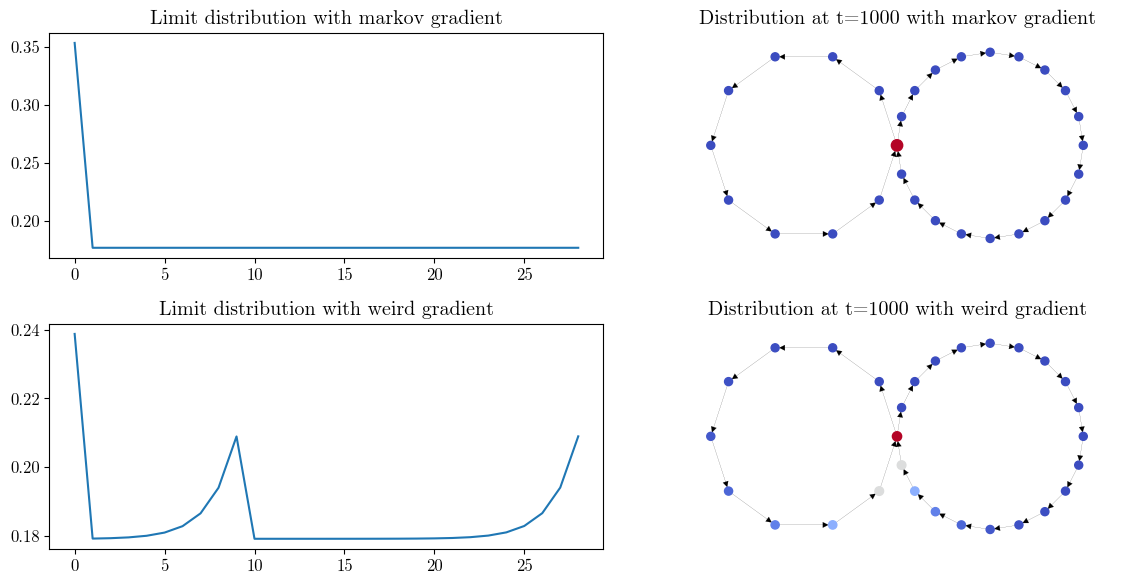

In [190]:
n=10
m=20

J = nx.DiGraph()
for u in range(n):
    J.add_edge(u, (u+1) % n, distance=1/n)
    J.nodes[u]['x'] = -1+math.cos(u*2*math.pi/n)
    J.nodes[u]['y'] = math.sin(u*2*math.pi/n)

for u in range(m):
    J.add_edge(-u, -((u+1) % m), distance=1/m)
    J.nodes[-u]['x'] = 1+math.cos(math.pi-u*2*math.pi/m)
    J.nodes[-u]['y'] = math.sin(math.pi-u*2*math.pi/m)
# for u in range(m):
#     J.add_edge(-u, -((u+4) % m), distance=4/m)

J = relabel_nodes(J)
G=J.to_undirected()

fig, ax = plt.subplots(2, 2, figsize=(12,6))
for i, discretization in enumerate(['markov', 'norm_backward']):
    D = g_gradient(J, type=discretization)
    values, vectors = sp.sparse.linalg.eigs(-D, k=1, sigma=0)
    f_eig = np.ndarray.flatten(np.real(vectors))
    ax[i,0].plot(abs(f_eig))
    ax[i,0].set_title(f'Limit distribution with {discretization} gradient')
    
    t = 100
    ft = np.zeros(len(G))
    ft[0] = 1
    ft  = expm(-t*D) @ ft
    draw_graph(J, ax=ax[i,1], node_color=ft, width=0.1, node_size=1000*ft, cmap='coolwarm')
    ax[i,1].set_title(f'Distribution at t={t} with {discretization} gradient')

plt.tight_layout()

## Valore atteso circolare

2.9999999999999973
0.4693033951206923
2.987678205730682


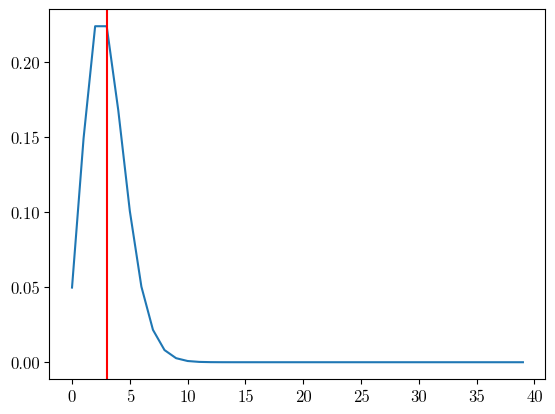

In [ ]:
n = 40

J = nx.DiGraph()
for u in range(n):
    J.add_edge(u, (u+1) % n, distance=1)
    J.nodes[u]['x'] = math.cos(u*2*math.pi/n)
    J.nodes[u]['y'] = math.sin(u*2*math.pi/n)

# J.add_edge(int(n/6), int(2*n/3), distance=1)

J = relabel_nodes(J)
G = J.to_undirected()

t = 3
# Graph advection
D = g_gradient(J, type='markov')
ft = np.zeros(len(G))
ft[0] = 1
ft  = expm(-t*D) @ ft

evx = 0
evy = 0
for u in J:
    evx += J.nodes[u]['x'] * ft[u]
    evy += J.nodes[u]['y'] * ft[u]

ev = np.arctan2(evy, evx)

print(sum([u*ft[u] for u in J.nodes]))

print(ev)
print((n * ev/(2*np.pi)) % n)

plt.plot(ft)
plt.axvline((n*ev/(2*np.pi)) % n, color='r')



## Retta reale simmetrica

In [ ]:
n = 20

np.random.seed(0)

J = nx.DiGraph()
J.add_node(0, x=0, y=0)
s = 0
for u in range(n):
    d = 2*np.random.rand() if u <= n/4 else 1
    J.add_edge(u, u+1, distance=d)
    s += d
    J.nodes[u+1]['x'] = s
    J.nodes[u+1]['y'] = 0
J.add_edge(n-1, n-1, distance=math.inf)

J.remove_edge(3,4)
J.add_edge(3, 5, distance=J.nodes[5]['x']-J.nodes[3]['x'])

for i in range(1,3):
    J.add_edge(0, i, distance=J.nodes[i]['x'])

for (u,v) in list(J.edges):
    J.add_edge(-u, -v, distance=J.edges[(u,v)]['distance'])
    J.nodes[-u]['x'] = -J.nodes[u]['x']
    J.nodes[-u]['y'] = 0
    J.nodes[-v]['x'] = -J.nodes[v]['x']
    J.nodes[-v]['y'] = 0  

J = relabel_nodes(J)

G = J.to_undirected()

t = 100

Db = g_gradient(J ,type='norm_backward')
DM = g_gradient(J ,type='markov')
ft = np.zeros(len(G))
ft[0] = 1
ftb  = expm(-t*Db) @ ft
ftM  = expm(-t*DM) @ ft
expected_value_b = sum([J.nodes[u]['x']*ftb[u] for u in J.nodes])
expected_value_M = sum([J.nodes[u]['x']*ftM[u] for u in J.nodes])
print(f'Expected value (mass-preserving backward gradient): \t {expected_value_b}')
print(f'Expected value (Markov gradient): \t\t\t {expected_value_M}')

Expected value (mass-preserving backward gradient): 	 0.0
Expected value (Markov gradient): 			 3.552713678800501e-15


## Isotropia

Expected value: (-0.00000000, 0.00000000)


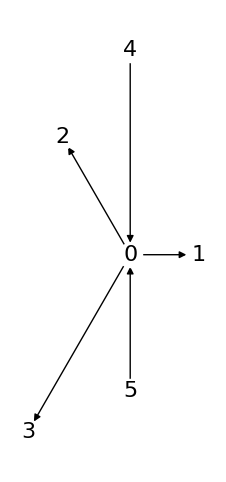

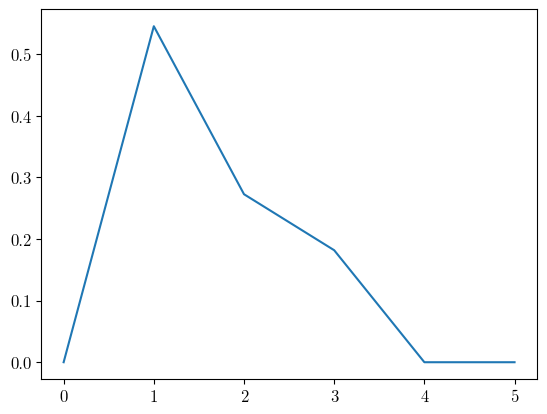

In [179]:
n=3
m=2

J = nx.DiGraph()

J.add_node(0, x=0, y=0)

for u in range(n):
    d = u+1#0.5+1.5*np.random.random()
    J.add_edge(0, u+1, distance=d)
    J.nodes[u+1]['x'] = d*math.cos(u*2*math.pi/n)
    J.nodes[u+1]['y'] = d*math.sin(u*2*math.pi/n)

    # h = 1.5+np.random.random()
    # J.add_edge(u+1, f'{u+1},1', distance=h)
    # J.nodes[f'{u+1},1']['x'] = (d+h)*math.cos(u*2*math.pi/n)
    # J.nodes[f'{u+1},1']['y'] = (d+h)*math.sin(u*2*math.pi/n)

    # J.add_edge(f'{u+1},1', f'{u+1},2', distance=h)
    # J.nodes[f'{u+1},2']['x'] = (d+2*h)*math.cos(u*2*math.pi/n)
    # J.nodes[f'{u+1},2']['y'] = (d+2*h)*math.sin(u*2*math.pi/n)
    
    # J.add_edge(f'{u+1},2', f'{u+1},3', distance=h)
    # J.nodes[f'{u+1},3']['x'] = (d+3*h)*math.cos(u*2*math.pi/n)
    # J.nodes[f'{u+1},3']['y'] = (d+3*h)*math.sin(u*2*math.pi/n)    
    
    # J.add_edge(u+1,u+1, distance=1)


for u in range(-m,0):
    d = -u+1#0.5+1.5*np.random.random()
    J.add_edge(u, 0, distance=d)
    J.nodes[u]['x'] = d*math.cos(u*2*math.pi/m+math.pi/m)
    J.nodes[u]['y'] = d*math.sin(u*2*math.pi/m+math.pi/m)
    # J.add_edge(u+1,u+1, distance=1)


J = relabel_nodes(J)
G=J.to_undirected()

plt.figure(figsize=(6,6))
draw_graph(J, with_labels=True, node_color='w', node_size=300)

D = g_gradient(J ,type='markov', s=0)

def one(v):
    vec = np.zeros(len(J))
    vec[v]=1
    return vec

# s = 0
# k=7
# for u in [k,k+1,k+2]:
#     print((D@D@one(0))[u])
#     s += nx.shortest_path_length(J, source=0, target=u, weight='distance')*(D@D@one(0))[u]

# print(-3*s)

# print((D@one(0))[0]-1/nx.shortest_path_length(J, source=0, target=k, weight='distance'))

# print((D@one(0))[k]*nx.shortest_path_length(J, source=0, target=k, weight='distance'))

# # for u in J.nodes:
# #     if len(list(J.successors(u))) == 0:
# #         D[u,u] = 1
# #         for v in J.nodes:
# #             if (v,u) in J.edges:
# #                 D[v,u] = -1


t = 100
ft = np.zeros(len(J))
ft[0] = 1
# ft = np.array([0, 1,2,3,0,0])
M = expm(-t*D)
ft = M @ ft

plt.figure()
plt.plot(ft)


evx = 0
evy = 0
for u in J:
    evx += J.nodes[u]['x'] * ft[u]
    evy += J.nodes[u]['y'] * ft[u]

print(f'Expected value: ({evx:.8f}, {evy:.8f})')

## Distanza dalla distribuzione limite

In [ ]:
n = 5

J = nx.DiGraph()
for u in range(n):
    J.add_edge(u, (u+1) % n, distance=1)
    J.nodes[u]['x'] = math.cos(u*2*math.pi/n)
    J.nodes[u]['y'] = math.sin(u*2*math.pi/n)

J.add_edge(int(n/6), int(2*n/3), distance=1)

# J.add_edge(int(n/6), int(n/2), distance=1)
# J.add_edge(int(n/6), int(0), distance=1)
# J.add_edge(int(n/2), int(n/3), distance=1)
# J.add_edge(int(n/2), int(n/4), distance=1)

for u in J:
    J.add_edge(0,u, distance=0.01)

J = relabel_nodes(J)
G=J.to_undirected()

ft = np.zeros(len(G))
ft[0] = 1

f_eig = expm(-100000*D) @ ft

print(f_eig)

print(expm(-1000*D))


# fig, ax = plt.subplots(1, 1, figsize=(6,6))
# for i, discretization in enumerate(['norm_backward', 'markov']):
#     D = g_gradient(J, type=discretization)

#     ft = np.zeros(len(G))
#     ft[0] = 1
   
#     f_eig = expm(-100000*D) @ ft
#     A = expm(-D)
#     iters = 200
#     err = np.zeros(iters)
#     err[0] = np.linalg.norm(f_eig-ft, 1)
#     for t in range(1, iters):
#         ft = A @ ft
#         err[t] = np.linalg.norm(f_eig-ft, 1)

#     print(np.polyfit(np.log(np.arange(1, iters+1)), err, 1))

#     ax.plot(err, label=discretization)
#     ax.plot(np.linspace(0,iters), np.exp(-0.0007*t*np.linspace(0,iters)), label=discretization)

#     ax.set_title(f'Error')
#     ax.set_yscale('log')
#     ax.legend()
 
# plt.tight_layout()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 6)

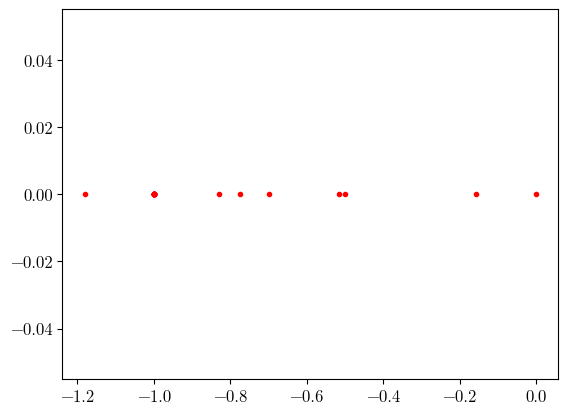

In [ ]:
D = g_gradient(J, type='markov')
eigenvalues = np.linalg.eigvals(-D)

# Plot the eigenvalues
plt.plot(np.real(eigenvalues), np.imag(eigenvalues), 'r.')  # Real part on x-axis, Imaginary part on y-axis


# Metro di Londra

Qualche esperimento su _advection-diffusion_ sulla metro di Londra.

In [ ]:
G = nx.Graph()

with open('london_tube_nodes.txt', 'r') as nodes_file:
    for line in nodes_file:
        node_id, label, x, y = line.strip().split()
        G.add_node(node_id, label=label, x=float(x), y=float(y))

with open('london_tube_edges.txt', 'r') as edges_file:
    next(edges_file)
    for line in edges_file:
        layer_id, node_id1, node_id2, edge_weight = line.strip().split()
        G.add_edge(node_id1, node_id2, layer_id=layer_id, weight=float(edge_weight))

G = relabel_nodes(G)

for (u,v) in G.edges:
    xu, yu = G.nodes[u]['x'], G.nodes[u]['y']
    xv, yv = G.nodes[v]['x'], G.nodes[v]['y']
    G.edges[u,v]['distance'] = np.sqrt((xu-xv)**2+(yv-yv)**2)

pos = {node: (G.nodes[node]['x'], G.nodes[node]['y']) for node in G.nodes}
labels = {node: G.nodes[node]['label'] for node in G.nodes}
# plt.figure(figsize=(35,35))
# nx.draw(G, with_labels=True, pos=pos, font_size = 16, node_size=1000, node_color='w')
# plt.show()

## Tragitto da un punto opposto all'altro

Consideriamo una massa concentrata su un nodo _source_ e un'orientazione $J$ che collega ogni nodo con il suo vicino più prossimo a un nodo _target_. Osserviamo che la massa si trasferisce più velocemente quando c'è meno diffusione.

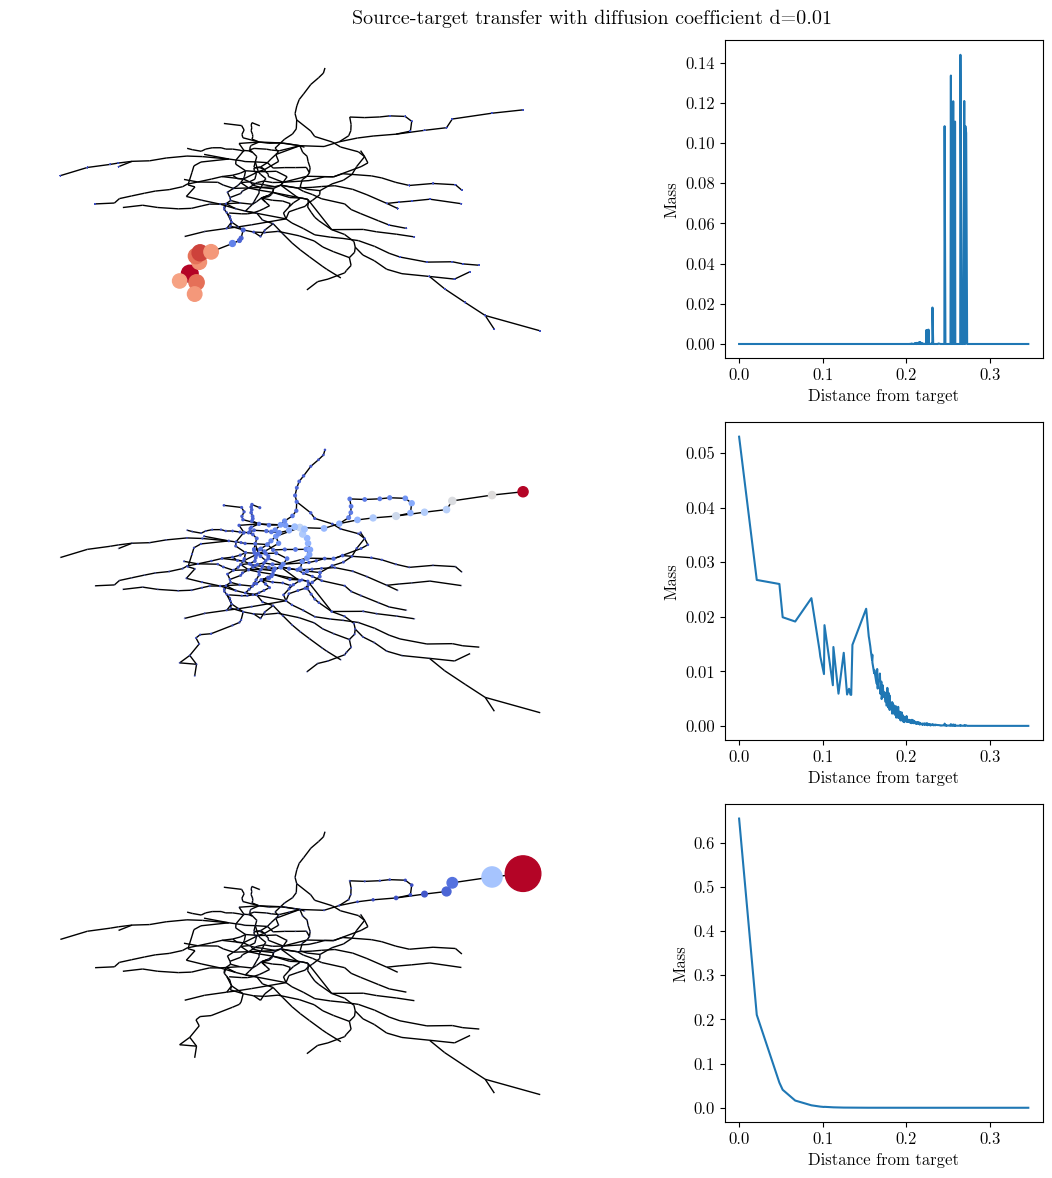

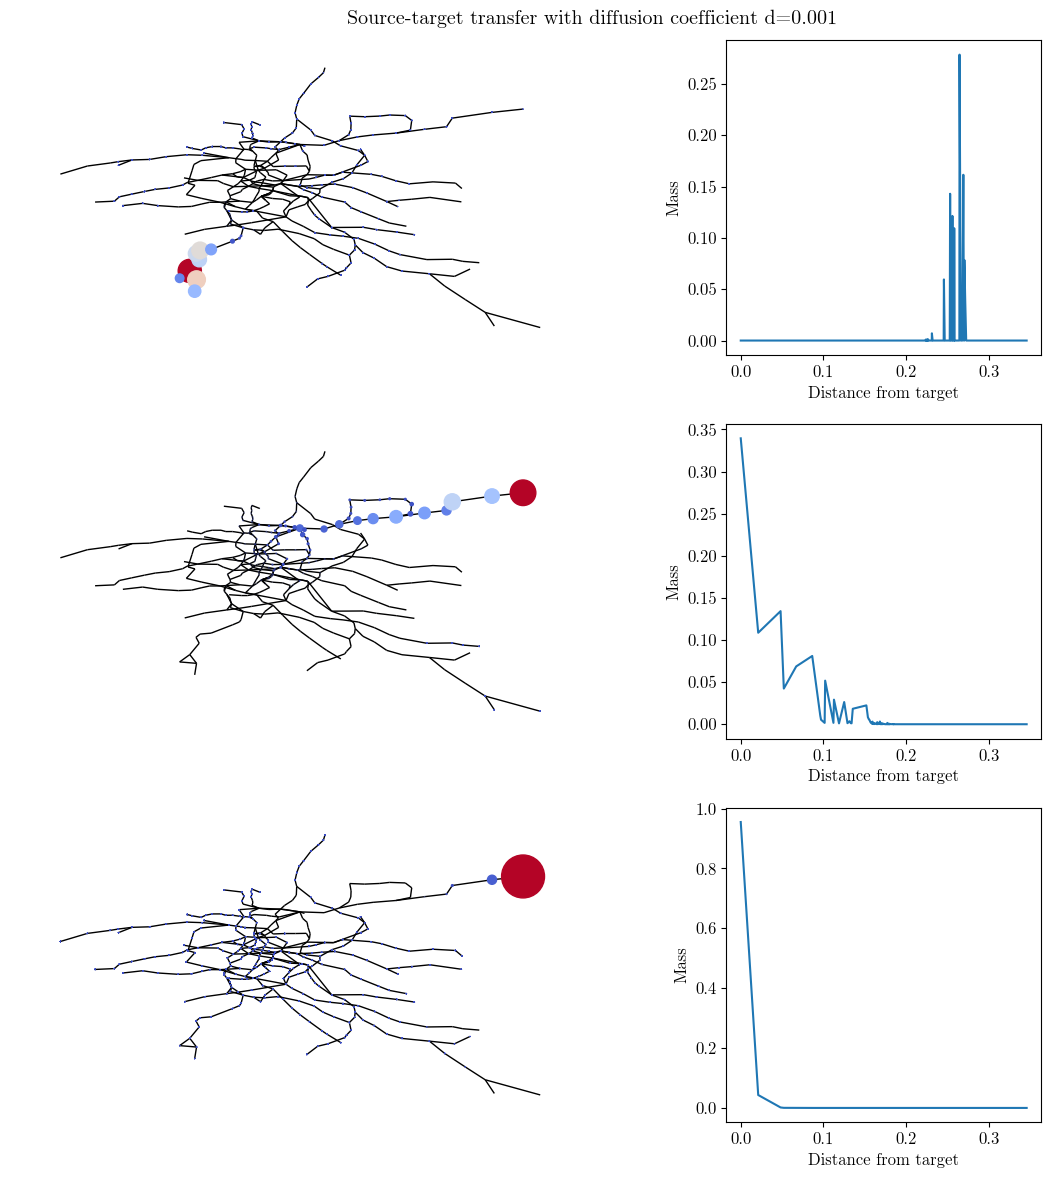

In [ ]:
target = 357
source = 238

J = G.copy().to_directed()
J.remove_edges_from(list(J.edges))

distances = nx.shortest_path_length(G, target=target, weight='distance')
for u in G:
    if u != target:
        best_direction = sorted(G.neighbors(u), key = lambda v: distances[v])[0]
        J.add_edge(u,best_direction, distance = G.edges[(u,best_direction)]['distance'])
    else:
        J.add_edge(u,u, distance = 1)

# plt.figure(figsize=(35,35))
# nx.draw(J, with_labels=True, pos=pos, font_size = 16, node_size=1000, node_color='w')

L = g_laplacian(G)
D = g_gradient(J)

for d in [0.01, 0.001]:

    fig, ax = plt.subplots(3, 2, figsize=(12,12))
    plt.suptitle(f'Source-target transfer with diffusion coefficient d={d}')
    for i,t in enumerate([0.01, 0.3, 10]):
        ft = np.zeros(len(G))
        ft[source] = 1
        ft = expm(-t*(d*L+D)) @ ft
        distribution = [y[1] for y in sorted(enumerate(list(ft)), key=lambda x: distances[x[0]])]

        nx.draw(G, ax=ax[i,0], with_labels=False, pos=pos, font_size = 6, node_color=ft, cmap='coolwarm', node_size=ft*1000)
        ax[i,1].plot(sorted(distances.values()), distribution)
        ax[i,1].set_xlabel('Distance from target')
        ax[i,1].set_ylabel('Mass')
        ax[i,1].set_box_aspect(1)    
    plt.tight_layout()


## Fuga da un punto

Consideriamo ora massa concentrata su un nodo centrale e un'orientazione $J$ che porta la massa a ``fuggire'' da tale nodo, costruita invertendo l'orientazione verso il nodo centrale. Il grafico ora rappresenta la distribuzione di massa a un tempo $t$ fissato. Osserviamo che per valori piccoli di diffusione, aggiungere diffusione aiuta i nodi ad allontanarsi più rapidamente dal nodo centrale (a parte nel caso di tempi grandi e diffusione grande). [Da capire questo comportamento, e da controllare che non sia dovuto a qualche questione tecnica su come si definisce l'orientazione.]

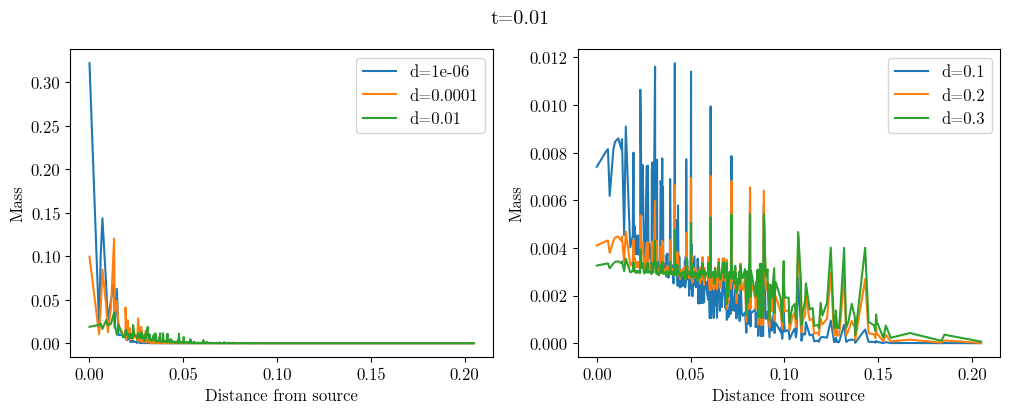

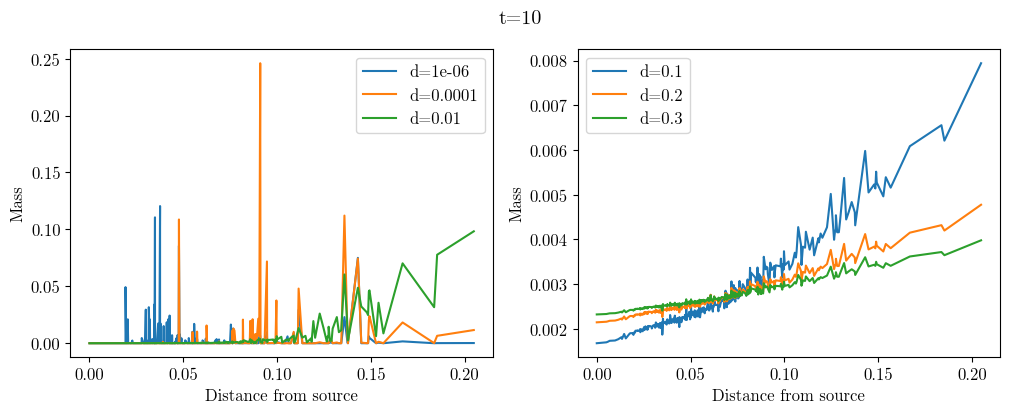

In [ ]:
source = 268

J = G.copy().to_directed()
J.remove_edges_from(list(J.edges))

distances = nx.shortest_path_length(G, target=source, weight='distance')
for u in G:
    if u != source:
        best_direction = sorted(G.neighbors(u), key = lambda v: distances[v])[0]
        J.add_edge(u,best_direction, distance = G.edges[(u,best_direction)]['distance'])
    else:
        J.add_edge(u,u, distance = 1)

J = J.reverse()

for u in J:
    if J.out_degree(u) == 0:
        J.add_edge(u,u, distance = 1)

ft = np.zeros(len(G))
ft[source] = 1

L = g_laplacian(G)
D = g_gradient(J)


for t in [0.01, 10]:
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    fig.suptitle(f't={t}')
    ft = np.zeros(len(G))
    ft[source] = 1
    for d in [0.000001, 0.0001, 0.01]:
        ft = expm(-t*(d*L+D)) @ ft

        distribution = [y[1] for y in sorted(enumerate(list(ft)), key=lambda x: distances[x[0]])]

        ax[0].plot(sorted(distances.values()), distribution, label=f'd={d}')
    ax[0].legend()
    ax[0].set_xlabel('Distance from source')
    ax[0].set_ylabel('Mass')

    for d in [0.1, 0.2, 0.3]: 
        ft = np.zeros(len(G))
        ft[source] = 1
        ft = expm(-t*(d*L+D)) @ ft

        distribution = [y[1] for y in sorted(enumerate(list(ft)), key=lambda x: distances[x[0]])]

        ax[1].plot(sorted(distances.values()), distribution, label=f'd={d}')
    ax[1].legend()
    ax[1].set_xlabel('Distance from source')
    ax[1].set_ylabel('Mass')

# plt.figure(figsize=(15,15))
# nx.draw(G, with_labels=False, pos=pos, font_size = 6, node_color=ft, cmap='coolwarm', node_size=ft*3000)
plt.show()


# Strade di Pisa

In [ ]:
# download street network data from OSM and construct a MultiDiGraph model
# street_map = ox.graph_from_place("Pisa, Italy", network_type="drive")
street_map = ox.graph_from_point((43.715049, 10.396794), dist=5000, network_type="drive")

# impute edge (driving) speeds and calculate edge traversal times
street_map = ox.add_edge_speeds(street_map)
street_map = ox.add_edge_travel_times(street_map)

# you can convert MultiDiGraph to/from geopandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(street_map)
street_map = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=street_map.graph)
street_map, labels = relabel_nodes(street_map, return_labels=True)

# convert MultiDiGraph to DiGraph to use nx.betweenness_centrality function
# choose between parallel edges by minimizing travel_time attribute value
G = ox.utils_graph.get_digraph(street_map, weight="travel_time").to_undirected()

# # calculate node betweenness centrality, weighted by travel time
# bc = nx.betweenness_centrality(D, weight="travel_time", normalized=True)
# nx.set_node_attributes(G, values=bc, name="bc")

for u in G:
    G.nodes[u]['pos'] = (G.nodes[u]['x'], G.nodes[u]['y'])

G.remove_edges_from(nx.selfloop_edges(G))

for u, v, data in G.edges(data=True):
    data["distance"] = data.pop("travel_time")

J = G.copy().to_directed()
J.remove_edges_from(list(J.edges))

target = labels[242960519]
distances = nx.shortest_path_length(G, target=target, weight='distance')
D = np.zeros((len(G), len(G)))
for u in G:
    if u != target:
        best_directions = sorted(G.neighbors(u), key = lambda v: distances[v])[0:1]
        for v in best_directions:
            J.add_edge(u,v, distance = G.edges[(u,v)]['distance'])

# draw_graph(G, node_size=.2, with_labels = False)

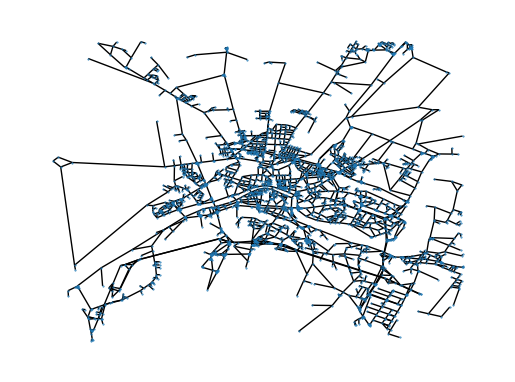

In [ ]:
draw_graph(G, node_size=.2, with_labels = False)

In [ ]:
D = g_gradient(J)
L = g_laplacian(G)

M = expm(-100*(D+L))

Consideriamo il tragitto tra Ospedaletto e Via di Gello. Osserviamo che il traffico si divide in due strade, una delle due apparentemente più trafficata: noto però che nella seconda i nodi sono meno densi, ed è quindi naturale che trattengano più massa.

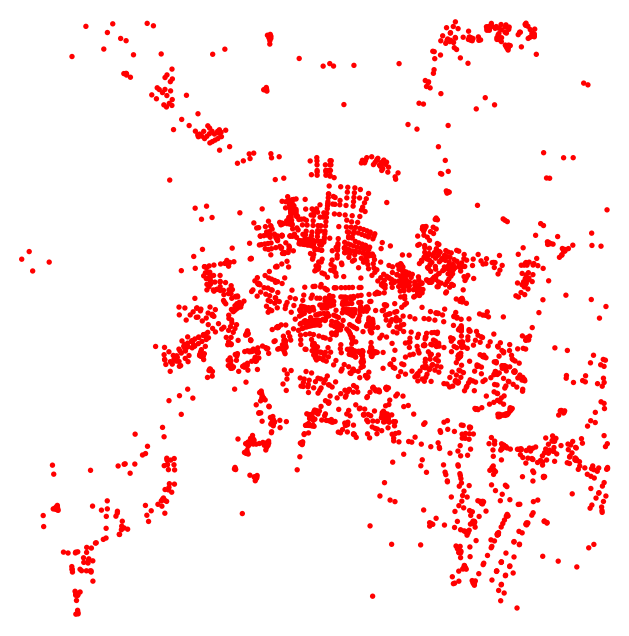

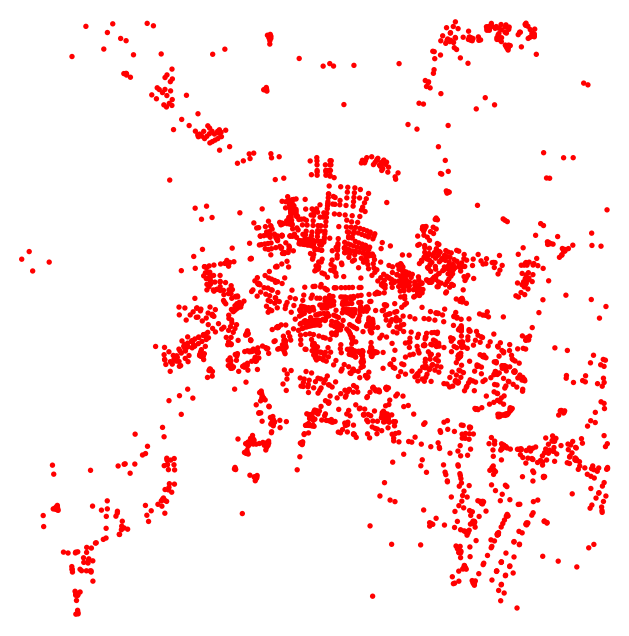

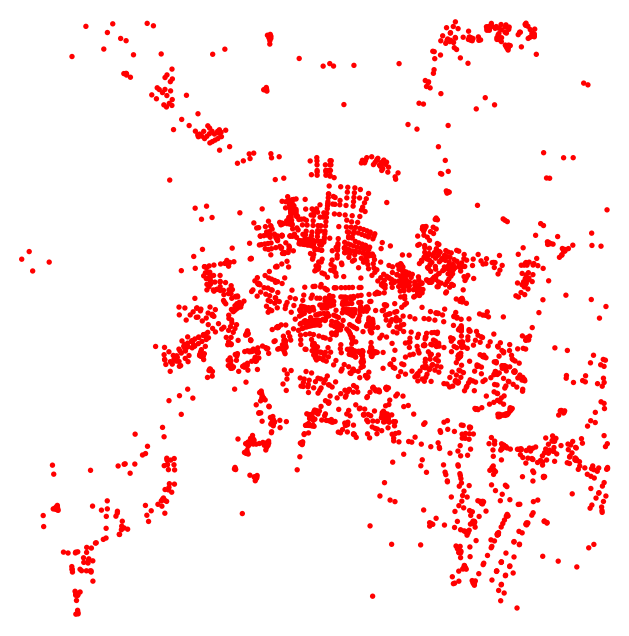

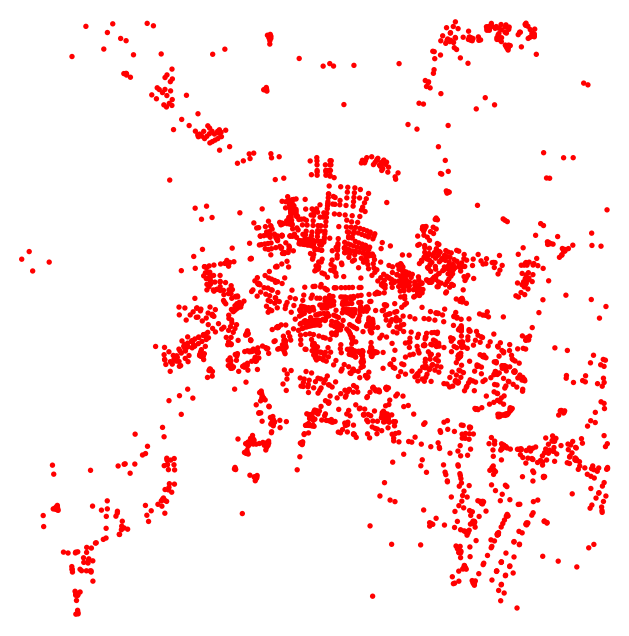

IndexError: index 5 is out of bounds for axis 0 with size 5

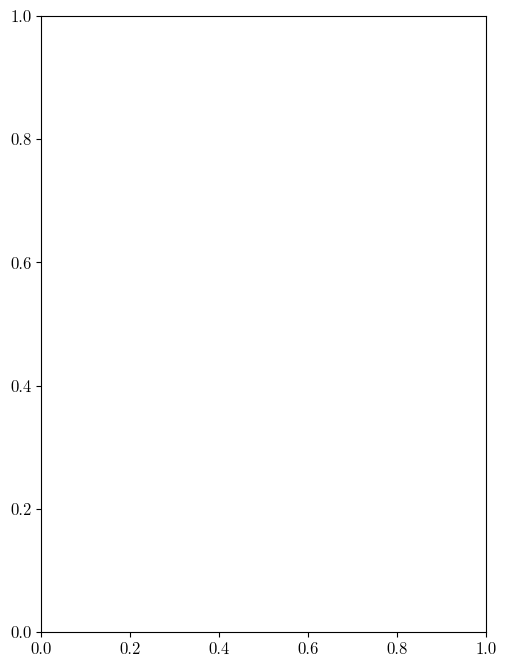

In [ ]:
ft = np.zeros(len(G))

cascina = ox.graph_from_point((43.683643796307756, 10.42889794443604), dist=100, network_type="drive")

# for u in cascina.nodes:
#     ft[labels[u]] = 1

# for i in range(4):

edge_widths = []
for (u,v,_) in street_map.edges:
    if (u,v) in J.edges:
        edge_widths.append(1000*np.sqrt(ft[u]*ft[v])/J.edges[(u,v)]['distance'])
    elif (v,u) in J.edges:
        edge_widths.append(1000*np.sqrt(ft[u]*ft[v])/J.edges[(v,u)]['distance'])
    else:
        edge_widths.append(1000)

    fig, ax = ox.plot_graph(
        street_map, bgcolor="w", node_color='r',
            edge_linewidth = edge_widths, edge_color="#333333",
        # show=False, save=True, filepath=filename,
    )
    fig.suptitle(f't={400*i}')
    plt.show()

    ft = M @ M @ M @ M @ ft

print(G.edges)

print(J.nodes)


In [ ]:
ft = np.zeros(len(G))

cascina = ox.graph_from_point((43.683643796307756, 10.42889794443604), dist=100, network_type="drive")

for u in cascina.nodes:
    ft[labels[u]] = 1

for i in range(4):

    f_dict = dict(enumerate(ft))
    nx.set_node_attributes(street_map, values=f_dict, name="f")

    nc = ox.plot.get_node_colors_by_attr(street_map, "f", cmap="coolwarm")

    fig, ax = ox.plot_graph(
        street_map, bgcolor="w", node_color='r', node_size=100*ft**(0.5), edge_linewidth=.5, edge_color="#333333",
        # show=False, save=True, filepath=filename,
    )
    fig.suptitle(f't={400*i}')
    plt.show()

    ft = M @ M @ M @ M @ ft



NameError: name 'labels' is not defined